# Tutorial1: Topic Modeling in Python

In [1]:
# Importing graphics related libraries
%matplotlib inline
import matplotlib
import seaborn as sns # plots prettier with Seaborn
import onlineldavb
from wordcloud import WordCloud
from IPython.display import Image
from IPython import display
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

# importing more useful libraries
import simplejson
import sys
import requests
from requests_oauthlib import OAuth1
from collections import Counter
import heapq
from nltk.corpus import stopwords
from sklearn.cluster import MiniBatchKMeans
from itertools import islice, chain
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pylab as plt

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Load Twitter authentication file

In [2]:
with open("twitter_secrets.json.nogit") as fh:
    secrets = simplejson.loads(fh.read())

## Stream tweets from US only

In [3]:
auth = OAuth1(
    secrets['api_key'],
    secrets['api_secret'],
    secrets['access_token'],
    secrets['access_token_secret']
)

US_BOUNDING_BOX = "-125.00,24.94,-66.93,49.59"

def tweet_generator():
    stream = requests.post('https://stream.twitter.com/1.1/statuses/filter.json',
                           auth=auth,
                           stream=True,
                           data={"locations" : US_BOUNDING_BOX})
    for line in stream.iter_lines():
        if not line:
            continue
        tweet = simplejson.loads(line)
        if 'text' in tweet:
            yield tweet['text']

In [6]:
for tweet in islice(tweet_generator(), 100):
    print tweet

😂😂😂 https://t.co/vLpYBmF5K2
El lunes ! O mañana de una vez ! Comemos ? https://t.co/vpIHMtqQO0
Not possible https://t.co/EtOBsAvrWF
@coconutboob @SiinniiTheGod sure boi
Daddy's little girls #NW 🎥💘
Managed to drive to and from 420 Munchies with a swollen eye. Okay, good night.
Apologizing for how you feel shouldn't be an option
@FRlEDPlCKLES 😂😂😂😂😂
sexiest blondie https://t.co/Nqt2D8UdXe
My life is either boring as fuck or 0 to 100 within a 24 hr span. Lord, help my ass.
anyone else get so upset to the point they feel physically sick?
Holy fuck. https://t.co/5xphKrFNwy
@DestTheBest9 https://t.co/C3Z4wUFbt3
Schöne Aussichten https://t.co/qVDQeqa0Xm
Tired of crying https://t.co/2DjJSHTd92
@Loganchance ...absolutely quackers!
#AddSportsRuinAMovie https://t.co/oGVL7oPKY7
Be feeling like riley cooper on dat liquor
It's time to step it up and slayyyy
😂😂😂😂 https://t.co/lnrzpq3uVW
I HAVE NO STRESS OR WORRIES. I LOVE MY LIFE
@_Valenciagaa you good?
Ayyyy this is super duper litty https://t.co/fhC

## Aggregate Statistics of words

[("i'm", 15), ("can't", 11), ('love', 10), ('like', 9), (u'&amp;', 9), (u'-&gt;', 8), (u'lol', 8), (u'new', 6), (u'still', 6), ('get', 6)]

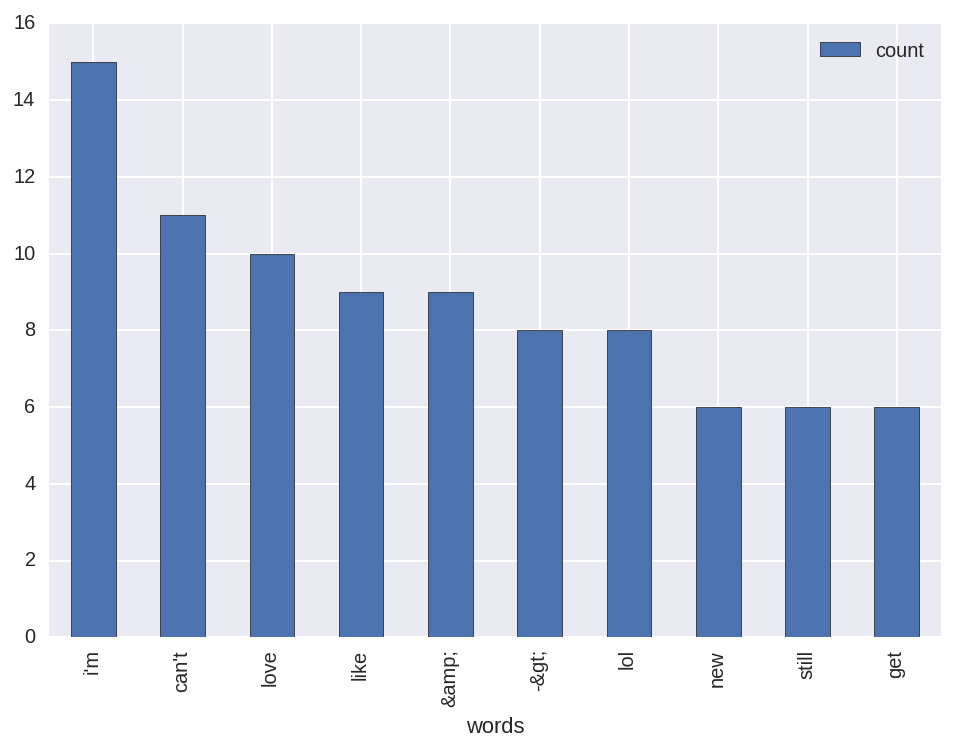

In [4]:
DISPLAY_EVERY = 20
stop = set(stopwords.words('english'))

counter = Counter()

def nlargest(n, word_scores):
    return heapq.nlargest(n, word_scores, key=lambda x: x[1])

try:
    for k, tweet in enumerate(islice(tweet_generator(), 1000)):
        for word in tweet.lower().split():
            if word not in stop:
                counter[word] += 1
        if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):
            sys.stdout.write("\r" + str(nlargest(10, counter.items())))
except KeyboardInterrupt:
    pass
finally:
    df = pd.DataFrame(nlargest(10, counter.items()), columns=['words', 'count'])
    df.set_index('words').plot(kind='bar')

## Visualize (Wordcloud)
1. List of word counts not as useful
2. Wordcloud: size of word ~ frequency 

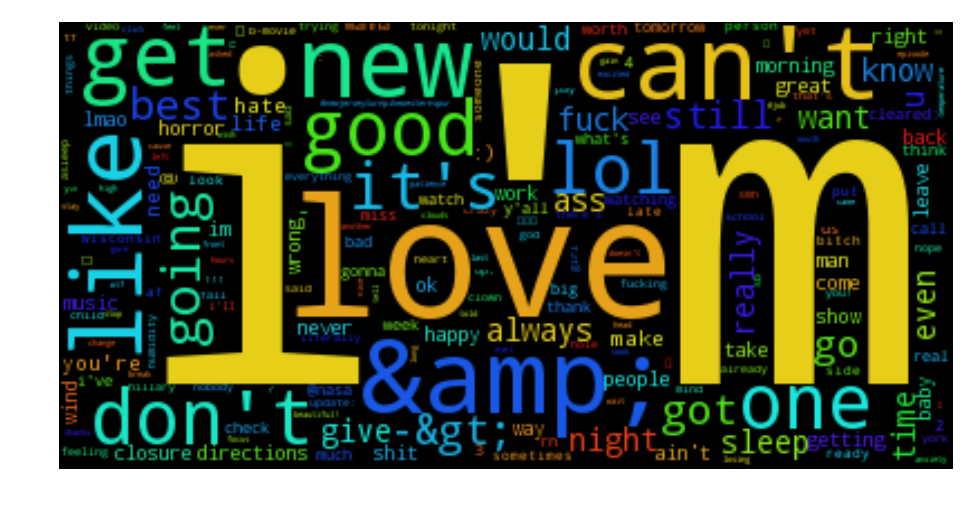

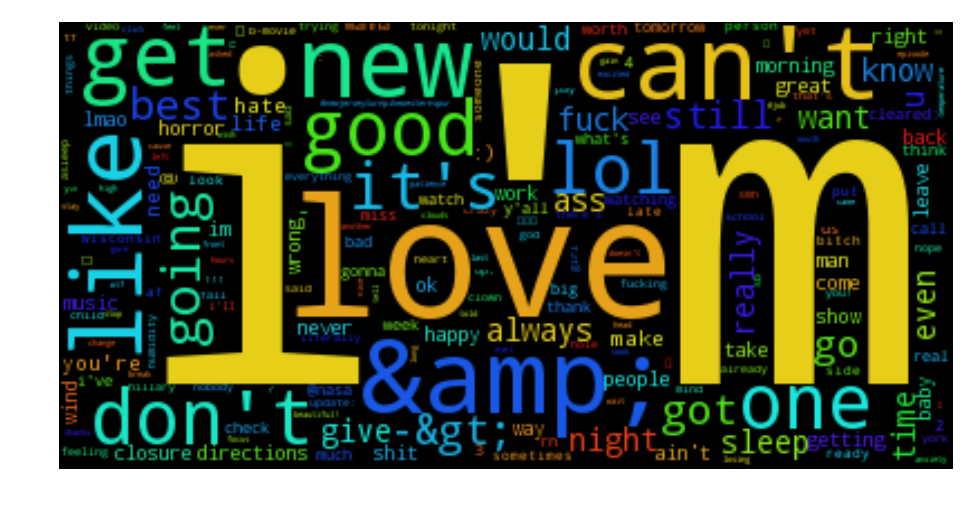

In [5]:
try:
    for k, tweet in enumerate(islice(tweet_generator(), 1000)):
        for word in tweet.lower().split():
            if word not in stop and 'http' not in word:
                counter[word] += 1
        if k % DISPLAY_EVERY == (DISPLAY_EVERY - 1):
            wordcloud = WordCloud().fit_words(counter.items())
            plt.axis("off")
            display.clear_output(wait=True)
            plt.imshow(wordcloud)
            display.display(plt.gcf())
except KeyboardInterrupt:
    pass

## Topic Modelling
1. Batch tweets (another generator)
2. Online vs offline
    A. streaming vs big data
3. Vectorization: convert word to index wwith a fixed vocabulary
    A. Static vs dynamic vocabulary
4. Use sparse matrices when data is sparse
5. We'll use KMeans to illustrate topic modelling
    A. Unsupervised learning
    B. Iteratively assign centers and update them

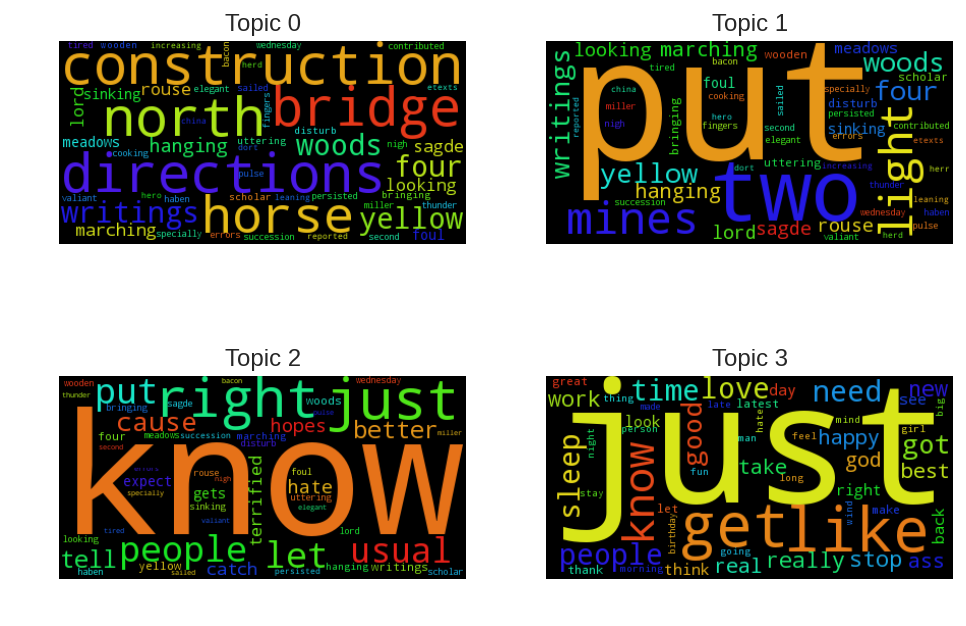

In [6]:
BATCH_SIZE = 20
CLUSTER_SIZE = 4

kmeans = MiniBatchKMeans(n_clusters=CLUSTER_SIZE)

def batch(iterable, size):
    """ batch("ABCDEFG", 3) -> ABC DEF G """
    sourceiter = iter(iterable)
    while True:
        batchiter = islice(sourceiter, size)
        yield chain([batchiter.next()], batchiter)
        
with open("dictnostops.txt") as fh:
    words = [line.strip() for line in fh.readlines()]
    word_to_index = {word : k for k, word in enumerate(words) }

def wordclouds(wordcounts):
    wordclouds = [WordCloud().fit_words(counts) for counts in wordcounts]
    fig, axes = plt.subplots(2,2)
    display.clear_output(wait=True)
    for k, (ax, wordcloud) in enumerate(zip(axes.flatten(), wordclouds)):
        ax.axis("off")
        ax.imshow(wordcloud)
        ax.set_title("Topic %d" % k)
    display.display(fig)
    fig.clear()
    
try:
    for tweets in batch(islice(tweet_generator(), 1000), BATCH_SIZE):
        mat = sp.sparse.dok_matrix((BATCH_SIZE, len(words)))
        for row, tweet in enumerate(tweets):
            for word in tweet.lower().split():
                if word in word_to_index:
                    mat[row, word_to_index[word]] = 1.
        kmeans.partial_fit(mat.tocsr())
        wordcounts = [
            nlargest(50, zip(words, kmeans.cluster_centers_[i]))
            for i in xrange(kmeans.n_clusters)
        ]
        wordclouds(wordcounts)
except KeyboardInterrupt:
    pass